In [1]:
import numpy as np, pandas as pd
from matplotlib import pyplot as plt
from matplotlib import ticker
%matplotlib inline

import utils

#### Helper functions

This one generates a number of counts for $n$ samples according to a Poisson distribution with parameter $l$.

In [2]:
def counts(l, n):
    samples = np.random.poisson(l,n)
    return pd.DataFrame(np.array([samples,samples]).T).groupby(0).count().to_records()

These ones generate $N$ jittered points around $(x,y)$:

In [3]:
import random

def jittered_xy(N, x, y, width_x=0.9, width_y=0.9):
    x_min, x_max = x-width_x/2, x+width_x/2
    y_min, y_max = y-width_y/2, y+width_y/2
    return [ (random.uniform(x_min, x_max), random.uniform(y_min, y_max))
             for i in range(N) ]

These ones generate $N$ regularly spaced points around $(x,y)$.

In [4]:
def spaced(N, x, dx):
    n = N//2
    if N % 2 == 1:
        return [x-dx*i for i in reversed(range(1,n+1))] + [x] + [x+dx*i for i in range(1,n+1)]
    else:
        return [x-dx*(i+0.5) for i in reversed(range(n))] + [x+dx*(i+0.5) for i in range(n)]

def shift_y(ps, dy):
    return [ (x,y+dy) for x,y in ps ]

def rows(N, n_max):
    return N//n_max + (1 if N%n_max else 0)

def ns(N, n_max):
    m = rows(N, n_max)
    n = N // m
    r = N % m
    return [n+1]*r + [n]*(m-r)

def shifts(N, n_max, dy):
    return spaced(rows(N, n_max), 0.0, dy)

def regular_xy(N, x, y, n_max=10, dx=0.1, dy=0.25):
    groups = zip(ns(N, n_max), shifts(N, n_max, dy))
    ps = []
    for n,dy in groups:
        ps += [ (x,y+dy) for x in spaced(n,x,dx) ]
    return ps

This one puts them together: 

In [5]:
def jitter_plot(ax, data, jitter=True, highlights=None, markersize=None, **kwargs):
    label_tag, value_tag, count_tag = data.columns
    labels = sorted(set(data[label_tag]))
    idx = np.arange(len(labels))
    ax.set_xlim(idx[0]-0.5, idx[-1]+0.5)
    ax.set_xticks(idx)
    ax.set_xticklabels(labels, fontsize=14)
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
    ax.xaxis.grid(True, 'minor', color='#999999')

    max_n = data[value_tag].max()
    idy = np.arange(max_n+1)
    ax.set_ylim(idy[0]-0.5, idy[-1]+0.5)
    ax.set_yticks(idy)
    ax.set_yticklabels(idy, fontsize=14)

    f = jittered_xy if jitter else regular_xy
    for l in labels:
        points = []
        column = data[data[label_tag] == l]
        x = labels.index(l)
        for y,c in zip(column[value_tag],column[count_tag]):
            points += f(c, x, y, **kwargs)
        xs, ys = zip(*sorted(points, key=lambda x: (x[1],x[0])))
        ax.plot(xs, ys, 'o', color='white', markersize=markersize, markeredgecolor='0.3')
        if highlights:
            for g,color in highlights:
                n = g(len(xs))
                ax.plot(xs[n:n+1], ys[n:n+1], 'o', color=color)

### Jitter plot

In [6]:
data = []
for l in 'ABCDEFGH':
    data += [ (l,i,n) for i,n in counts(2,500) ]
data = pd.DataFrame(data)

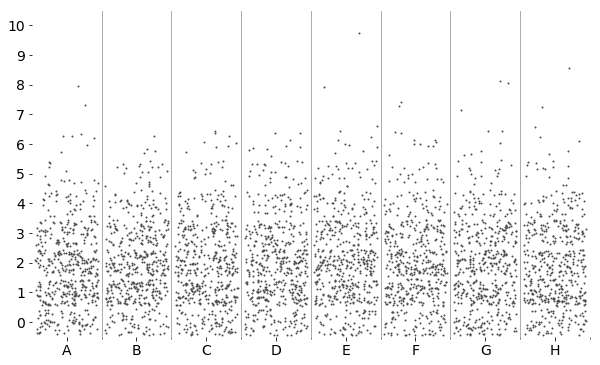

In [7]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
utils.despine(ax)

jitter_plot(ax, data, jitter=True, markersize=1)

### "Regular" jitter plot

In [8]:
data = []
for l in 'ABCDEFGH':
    data += [ (l,i,n) for i,n in counts(2,30) ]
data = pd.DataFrame(data)

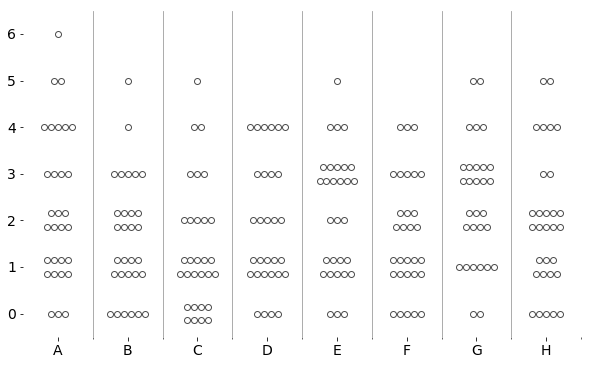

In [9]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
utils.despine(ax)

jitter_plot(ax, data, jitter=False, n_max=6, dy=0.3)

### A more complex example

This one reverts the $y$ axis and uses color to highlight bands and to mark the last and median point.

In [10]:
data = []
for l in 'ABCDEFGH':
    data += [ (l,i,n) for i,n in counts(2,30) ]
data = pd.DataFrame(data, columns=['label','value','count'])

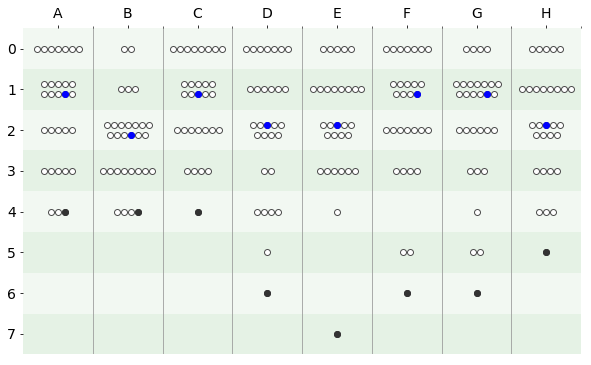

In [11]:
def last(N):
    return N-1

def median(N):
    return N//2

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
utils.despine(ax)

max_n = data['value'].max()

ax.xaxis.tick_top()
for i in range(max_n+1):
    color, alpha = ('green', 0.1) if i%2 else ('green', 0.05)
    ax.axhspan(i-0.5,i+0.5,facecolor=color, alpha=alpha)

jitter_plot(ax, data, jitter=False, n_max=8,
            highlights=[(median, 'blue'),
                        (last, '0.2')])

ax.invert_yaxis()